# Importing Libraries

In [1]:
#importing libs
import warnings, datetime, csv,itertools, pandas as pd, matplotlib.pyplot as plt
import numpy as np
# for csv data 
from pandas import DataFrame
from pandas import concat
from pandas import Series 
# for normalization and scaling
# for normalization and scaling
from sklearn import preprocessing
# for measuring the accuracy of the model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
# models for fitting and predicting
from sklearn import tree
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
# for correlation plotting
from pandas.tools.plotting import lag_plot
# for preventing warnings messages
# for preventing warnings messages
from __future__ import division
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
from keras.optimizers import Adam
from keras import layers
from functools import reduce
from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.layers import RepeatVector,TimeDistributed,Activation
from scipy import stats
warnings.filterwarnings('ignore')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Reading Hog Island data

In [2]:
#reading the dataset and converting date & time column into datetime obj
f=pd.read_csv('/home/reem/Desktop/codes/WQ/HogIsland.csv')
keep_col = ['agency_cd','site_no','datetime','tz_cd','106605_00095','106608_00300','106611_62361','106617_63680']
new_f = f[keep_col]
new_f['datetime'] =  pd.to_datetime(new_f['datetime'])
new_f = new_f[['agency_cd','site_no','datetime','106605_00095','106608_00300','106611_62361','106617_63680']]
new_f = new_f.rename(columns={'106605_00095': 'Specific Conductance', '106608_00300': 'Dissolved Oxygen', '106611_62361': 'Chlorophyll', '106617_63680': 'Turbidity'})
new_f.head(2)

,agency_cd,site_no,datetime,Specific Conductance,Dissolved Oxygen,Chlorophyll,Turbidity
0,USGS,1311143,2010-10-21 00:00:00,44900.0,6.8,3.2,NaN
1,USGS,1311143,2010-10-21 00:06:00,44800.0,6.9,3.5,NaN


In [3]:
HogIsland1 = pd.read_csv('/home/reem/Desktop/codes/WQ/wqfull1.csv')
keep_col1 = ['datetime','tz_cd','106604_00010','106612_00003','106616_00400','106618_32318']
new_f1 = HogIsland1[keep_col1]
new_f1['datetime'] =  pd.to_datetime(new_f1['datetime']+ ' ' + new_f1['tz_cd'])
new_f1 = new_f1[['datetime','106604_00010','106612_00003','106616_00400','106618_32318']]
new_f1 = new_f1.rename(columns={'106604_00010': 'Sampling depth', '106612_00003': 'Temperature', '106616_00400': 'pH', '106618_32318': 'Chlorophylls'})
new_f1.head(2)

,datetime,Sampling depth,Temperature,pH,Chlorophylls
0,2010-10-21 00:00:00,14.2,NaN,NaN,NaN
1,2010-10-21 00:06:00,14.3,NaN,NaN,NaN


In [4]:
HogIsland2 = pd.read_csv('/home/reem/Desktop/codes/WQ/wqfull2.csv')
keep_col2 = ['datetime','tz_cd','106595_62619','106596_62619','106607_90860','106615_99137','167659_99067']
new_f2 = HogIsland2[keep_col2]
new_f2['datetime'] =  pd.to_datetime(new_f2['datetime']+ ' ' + new_f2['tz_cd'])
new_f2 = new_f2[['datetime','106595_62619','106596_62619','106607_90860','106615_99137','167659_99067']]
new_f2 = new_f2.rename(columns={'106595_62619': 'Elevation', '106596_62619': 'Elevation/tidal prediction', '106607_90860': 'Salinity', '106615_99137': 'Nitrate', '167659_99067': 'diff obs/pred elev'})
new_f2.head(2)

,datetime,Elevation,Elevation/tidal prediction,Salinity,Nitrate,diff obs/pred elev
0,2010-10-21 00:00:00,-0.49,NaN,29.0,NaN,NaN
1,2010-10-21 00:06:00,-0.51,NaN,28.9,NaN,NaN


In [5]:
print(new_f.shape,new_f1.shape,new_f2.shape)

(606736, 7) (606851, 5) (637664, 6)


# Combine the dataset in one

In [6]:
#  test = pd.concat([new_f.set_index('datetime'),new_f1.set_index('datetime')])
# test = pd.concat([new_f,new_f1] , axis=1)
test = pd.merge(new_f, new_f1, left_index=True, right_index=True, how='outer')
test = pd.merge(test, new_f2, left_index=True, right_index=True, how='outer')
test.head(2)

,agency_cd,site_no,datetime_x,Specific Conductance,Dissolved Oxygen,Chlorophyll,Turbidity,datetime_y,Sampling depth,Temperature,pH,Chlorophylls,datetime,Elevation,Elevation/tidal prediction,Salinity,Nitrate,diff obs/pred elev
0,USGS,1311143.0,2010-10-21 00:00:00,44900.0,6.8,3.2,NaN,2010-10-21 00:00:00,14.2,NaN,NaN,NaN,2010-10-21 00:00:00,-0.49,NaN,29.0,NaN,NaN
1,USGS,1311143.0,2010-10-21 00:06:00,44800.0,6.9,3.5,NaN,2010-10-21 00:06:00,14.3,NaN,NaN,NaN,2010-10-21 00:06:00,-0.51,NaN,28.9,NaN,NaN


In [7]:
# test=test.set_index('datetime')
# test.head(2)

# Reading RockAway data

In [8]:
df_rockaway = pd.read_csv('/home/reem/Desktop/codes/WQ/rockaway1.csv')
df_rockaway['datetime'] =  pd.to_datetime(df_rockaway['datetime']+ ' ' + df_rockaway['tz_cd'])
df_rockaway = df_rockaway[['datetime','167863_62619','167866_00010','167867_00095','167868_90860','167869_63680']]
df_rockaway = df_rockaway.rename(columns={'167863_62619':'Elevation','167866_00010':'Temperature','167867_00095':'Specific Conductance','167868_90860':'Salinity','167869_63680':'Turbidity'})
df_rockaway.head(2)

,datetime,Elevation,Temperature,Specific Conductance,Salinity,Turbidity
0,2014-11-21 00:00:00,-2.43,6.4,45900.0,29.7,3.0
1,2014-11-21 00:06:00,-2.47,6.4,45900.0,29.7,3.1


# MLP Model

In [9]:
warnings.filterwarnings('ignore')
df = test

FeaturesHogIsland = ['Elevation','Temperature','Specific Conductance','Salinity','Turbidity']

acc_list = []
model_list = []
pred_list = []
act_list = []

for i in FeaturesHogIsland:
    var = i
    mylist = df.groupby([df['datetime'].dt.date])
    xx = mylist[var].apply(list)
    date_measurements = [xx[i] for i in range(len(xx)) if len(xx[i])==240]
    date_measurements = np.array(date_measurements)
    inds = np.where(np.isnan(date_measurements))
    badind = list(set(inds[0]))
    date_measurements = np.delete(date_measurements, ([i for i in badind]), axis=0)
    inp = [date_measurements[i][j] for i in range(len(date_measurements)) for j in range(0,240,40)]
    inp = np.array(inp)
    print(var,'\n',stats.describe(inp)) 
    scaler = MinMaxScaler(feature_range=(0, 1))
    inp = scaler.fit_transform(inp.reshape(-1, 1))
    inp = inp.reshape(len(date_measurements),6)
    print(inp.shape)
    out = inp[1:][:]
    inp = inp[:-1][:]
    stop = int(len(inp)*0.8)
    x_train = inp[:stop][:]
    y_train = out[:stop][:]
    x_test = inp[stop:][:]
    y_test = out[stop:][:]
    #Multi-Layer Perceptron
    MLP = MLPRegressor(hidden_layer_sizes=(10),  activation='relu', solver='adam', random_state=1)
    MLP = MLP.fit(x_train, y_train)
    y_predict = MLP.predict(x_test)
    y_predict = scaler.inverse_transform(y_predict)
    y_test = scaler.inverse_transform(y_test)
    acc = mean_squared_error(y_test, y_predict)
    model_list.append(MLP)
    pred_list.append(y_predict)
    act_list.append(y_test)
    acc_list.append(acc)
print(acc_list)

Elevation 
 DescribeResult(nobs=14760, minmax=(-3.81, 10.84), mean=1.3243766937669377, variance=2.9491900986233928, skewness=0.026330503808115583, kurtosis=-0.8119138738019513)
(2460, 6)
Temperature 
 DescribeResult(nobs=516, minmax=(1.7, 10.8), mean=6.446201550387596, variance=2.9130907864830284, skewness=0.0684056401521753, kurtosis=-0.7419241304492981)
(86, 6)
Specific Conductance 
 DescribeResult(nobs=13650, minmax=(33300.0, 57400.0), mean=45774.23443223443, variance=5027359.385289534, skewness=-0.007809753894037238, kurtosis=3.9672413538226072)
(2275, 6)
Salinity 
 DescribeResult(nobs=13698, minmax=(20.1, 38.1), mean=29.656438896189226, variance=2.6249453960251237, skewness=0.08562229943613374, kurtosis=4.400997167978529)
(2283, 6)
Turbidity 
 DescribeResult(nobs=8016, minmax=(0.4, 57.0), mean=3.092015968063872, variance=3.476919403862269, skewness=5.803626649708199, kurtosis=110.12008623484408)
(1336, 6)
[1.6422141514481847, 2.510668637656565, 807924.0198219348, 0.401027261041557

In [10]:
x_train.shape, y_train.shape , x_test.shape, y_test.shape 

((1068, 6), (1068, 6), (267, 6), (267, 6))

In [11]:
# import statsmodels.api as sm
# plt.style.use('fivethirtyeight')

# for i in range(5):
#     print('\n')
#     plt.figure(figsize=(16,8))
#     plt.plot(act_list[i].flatten(),alpha=0.6)
#     plt.plot(pred_list[i].flatten(),"k-")
#     plt.margins(0,0)
#     plt.grid()
#     plt.xlabel('Hours')
#     plt.ylabel(FeaturesHogIsland[i]+' Measurements')
#     plt.show()

# LSTM Hog Island

In [12]:
warnings.filterwarnings('ignore')
df = test

FeaturesHogIsland = ['Elevation','Temperature','Specific Conductance','Salinity','Turbidity']

acc_list1 = []
model_list1 = []
pred_list1 = []
act_list1 = []

for i in FeaturesHogIsland:
    var = i
    mylist = df.groupby([df['datetime'].dt.date])
    xx = mylist[var].apply(list)
    date_measurements = [xx[i] for i in range(len(xx)) if len(xx[i])==240]
    date_measurements = np.array(date_measurements)
    inds = np.where(np.isnan(date_measurements))
    badind = list(set(inds[0]))
    date_measurements = np.delete(date_measurements, ([i for i in badind]), axis=0)

    inp = [date_measurements[i][j] for i in range(len(date_measurements)) for j in range(0,240,40)]
    inp = np.array(inp)
    print(var,'\n',stats.describe(inp))
    scaler = MinMaxScaler(feature_range=(0, 1))
    inp = scaler.fit_transform(inp.reshape(-1, 1))
    
    inp = inp.reshape(len(date_measurements),6)
    print(inp.shape)

    out = inp[1:][:]
    inp = inp[:-1][:]

    stop = int(len(inp)*0.8)
    x_train = inp[:stop][:]
    y_train = out[:stop][:]
    x_test = inp[stop:][:]
    y_test = out[stop:][:]

    #Multi-Layer Perceptron
    def create_model(steps_before, steps_after, feature_count):
        model = Sequential()
        model.add(LSTM(input_dim=feature_count, output_dim=10, return_sequences=False))
        model.add(RepeatVector(steps_after))
        model.add(LSTM(output_dim=10, return_sequences=True))
        model.add(TimeDistributed(Dense(feature_count)))
        model.add(Activation('linear'))  
        model.compile(loss='mean_squared_error', optimizer='adam')  
        return model

    train_X_reshaped = x_train.reshape((x_train.shape[0], 6, 1))
    test_X_reshaped = x_test.reshape((x_test.shape[0], 6, 1))
    train_y_reshaped = y_train.reshape((y_train.shape[0], 6, 1))
    test_y_reshaped = y_test.reshape((y_test.shape[0], 6, 1))
    model = create_model(6, 6, 1)
    history = model.fit(train_X_reshaped, train_y_reshaped, batch_size=1, epochs=1, validation_split=0.2, verbose=0)
    y_predict = model.predict(test_X_reshaped)
    
    nsamples, nx, ny = test_y_reshaped.shape
    test_y_reshaped = test_y_reshaped.reshape((nsamples,nx*ny))
    y_predict = y_predict.reshape((nsamples,nx*ny))

    y_predict = scaler.inverse_transform(y_predict)
    y_test = scaler.inverse_transform(test_y_reshaped)

    testScore = mean_squared_error(y_test, y_predict)
    
    acc = mean_squared_error(y_test, y_predict)
    model_list1.append(model)
    pred_list1.append(y_predict)
    act_list1.append(y_test)
    acc_list1.append(acc)
    
print(acc_list1)

Elevation 
 DescribeResult(nobs=14760, minmax=(-3.81, 10.84), mean=1.3243766937669377, variance=2.9491900986233928, skewness=0.026330503808115583, kurtosis=-0.8119138738019513)
(2460, 6)
Temperature 
 DescribeResult(nobs=516, minmax=(1.7, 10.8), mean=6.446201550387596, variance=2.9130907864830284, skewness=0.0684056401521753, kurtosis=-0.7419241304492981)
(86, 6)
Specific Conductance 
 DescribeResult(nobs=13650, minmax=(33300.0, 57400.0), mean=45774.23443223443, variance=5027359.385289534, skewness=-0.007809753894037238, kurtosis=3.9672413538226072)
(2275, 6)
Salinity 
 DescribeResult(nobs=13698, minmax=(20.1, 38.1), mean=29.656438896189226, variance=2.6249453960251237, skewness=0.08562229943613374, kurtosis=4.400997167978529)
(2283, 6)
Turbidity 
 DescribeResult(nobs=8016, minmax=(0.4, 57.0), mean=3.092015968063872, variance=3.476919403862269, skewness=5.803626649708199, kurtosis=110.12008623484408)
(1336, 6)
[0.5141062684497314, 3.1733390567461384, 677555.5190982803, 0.18146740631983

In [13]:
# import statsmodels.api as sm
# plt.style.use('fivethirtyeight')

# for i in range(5):
#     print('\n')
#     plt.figure(figsize=(16,8))
#     plt.plot(act_list1[i].flatten(),'r-',alpha=0.6)
#     plt.plot(pred_list1[i].flatten(),"k-")
#     plt.margins(0,0)
#     plt.grid()
#     plt.xlabel('Hours')
#     plt.ylabel(FeaturesHogIsland[i]+' Measurements')
#     plt.show()

# MLP Rockaway Inlet

In [14]:
df = df_rockaway

FeaturesHogIsland = ['Elevation','Temperature','Specific Conductance','Salinity','Turbidity']

acc_list2 = []
model_list2 = []
pred_list2 = []
act_list2 = []

for i in FeaturesHogIsland:
    var = i
    mylist = df.groupby([df['datetime'].dt.date])
    xx = mylist[var].apply(list)
    date_measurements = [xx[i] for i in range(len(xx)) if len(xx[i])==240]
    date_measurements = np.array(date_measurements)
    inds = np.where(np.isnan(date_measurements))
    badind = list(set(inds[0]))
    date_measurements = np.delete(date_measurements, ([i for i in badind]), axis=0)

    inp = [date_measurements[i][j] for i in range(len(date_measurements)) for j in range(0,240,40)]
    inp = np.array(inp)
    print(var,'\n',stats.describe(inp))
    scaler = MinMaxScaler(feature_range=(0, 1))
    inp = scaler.fit_transform(inp.reshape(-1, 1))
    inp = inp.reshape(len(date_measurements),6)
    inp = inp[:(int(len(inp)*0.5))][:]
    print(inp.shape)

    out = inp[1:][:]
    inp = inp[:-1][:]

    stop = int(len(inp)*0.6)
    x_train = inp[:stop][:]
    y_train = out[:stop][:]
    x_test = inp[stop:][:]
    y_test = out[stop:][:]

    #Multi-Layer Perceptron
    MLP = MLPRegressor(hidden_layer_sizes=(10),  activation='relu', solver='adam', random_state=1)
    MLP = MLP.fit(x_train, y_train)
    y_predict = MLP.predict(x_test)
    
    y_predict = scaler.inverse_transform(y_predict)
    y_test = scaler.inverse_transform(y_test)

    acc = mean_squared_error(y_test, y_predict)
    model_list2.append(MLP)
    pred_list2.append(y_predict)
    act_list2.append(y_test)
    acc_list2.append(acc)
    
print(acc_list2)

Elevation 
 DescribeResult(nobs=7122, minmax=(-4.49, 6.63), mean=1.0441996630160066, variance=3.8199825148264557, skewness=0.031264629735598244, kurtosis=-0.9078651398102839)
(593, 6)
Temperature 
 DescribeResult(nobs=6624, minmax=(-1.7, 27.9), mean=12.930993357487921, variance=59.22970965781486, skewness=0.11612473171872587, kurtosis=-1.3378433820575406)
(552, 6)
Specific Conductance 
 DescribeResult(nobs=5664, minmax=(37400.0, 53200.0), mean=45842.51412429378, variance=3360141.7268002923, skewness=0.03751499255906756, kurtosis=0.5768687395402283)
(472, 6)
Salinity 
 DescribeResult(nobs=6678, minmax=(0.3, 37.6), mean=27.155944893680743, variance=62.208671407476544, skewness=-2.63046809259408, kurtosis=5.341193276722057)
(556, 6)
Turbidity 
 DescribeResult(nobs=4446, minmax=(0.2, 40.0), mean=2.71689158794422, variance=2.7576381196277593, skewness=4.517468354412315, kurtosis=64.9524462240701)
(370, 6)
[1.8553295270916168, 5.835434928708857, 2946065.658107663, 30.27569654260039, 5.005805

In [15]:
# import statsmodels.api as sm
# plt.style.use('fivethirtyeight')

# for i in range(5):
#     print('\n')
#     plt.figure(figsize=(16,8))
#     plt.plot(act_list[i].flatten(),alpha=0.6)
#     plt.plot(pred_list[i].flatten(),"k-")
#     plt.margins(0,0)
#     plt.grid()
#     plt.xlabel('Hours')
#     plt.ylabel(FeaturesHogIsland[i]+' Measurements')
#     plt.show()

# LSTM Rockaway

In [ ]:
def create_model(steps_before, steps_after, feature_count):
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=10, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(LSTM(output_dim=10, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))  
    model.compile(loss='mean_squared_error', optimizer='adam')  
    return model

In [16]:
warnings.filterwarnings('ignore')
df = df_rockaway

FeaturesHogIsland = ['Elevation','Temperature','Specific Conductance','Salinity','Turbidity']

acc_list3 = []
model_list3 = []
pred_list3 = []
act_list3 = []

for i in FeaturesHogIsland:
    var = i
    mylist = df.groupby([df['datetime'].dt.date])
    xx = mylist[var].apply(list)
    date_measurements = [xx[i] for i in range(len(xx)) if len(xx[i])==240]
    date_measurements = np.array(date_measurements)
    inds = np.where(np.isnan(date_measurements))
    badind = list(set(inds[0]))
    date_measurements = np.delete(date_measurements, ([i for i in badind]), axis=0)

    inp = [date_measurements[i][j] for i in range(len(date_measurements)) for j in range(0,240,40)]
    inp = np.array(inp)
    print(var,'\n',stats.describe(inp))
    scaler = MinMaxScaler(feature_range=(0, 1))
    inp = scaler.fit_transform(inp.reshape(-1, 1))
    inp = inp.reshape(len(date_measurements),6)
    inp = inp[:(int(len(inp)*0.5))][:]
    print(inp.shape)

    out = inp[1:][:]
    inp = inp[:-1][:]

    stop = int(len(inp)*0.8)
    x_train = inp[:stop][:]
    y_train = out[:stop][:]
    x_test = inp[stop:][:]
    y_test = out[stop:][:]

    train_X_reshaped = x_train.reshape((x_train.shape[0], 6, 1))
    test_X_reshaped = x_test.reshape((x_test.shape[0], 6, 1))
    train_y_reshaped = y_train.reshape((y_train.shape[0], 6, 1))
    test_y_reshaped = y_test.reshape((y_test.shape[0], 6, 1))
    model = create_model(6, 6, 1)
    history = model.fit(train_X_reshaped, train_y_reshaped, batch_size=1, epochs=1, validation_split=0.2, verbose=0)
    y_predict = model.predict(test_X_reshaped)
    
    nsamples, nx, ny = test_y_reshaped.shape
    test_y_reshaped = test_y_reshaped.reshape((nsamples,nx*ny))
    y_predict = y_predict.reshape((nsamples,nx*ny))

    y_predict = scaler.inverse_transform(y_predict)
    y_test = scaler.inverse_transform(test_y_reshaped)

    testScore = mean_squared_error(y_test, y_predict)
    
    acc = mean_squared_error(y_test, y_predict)
    model_list3.append(model)
    pred_list3.append(y_predict)
    act_list3.append(y_test)
    acc_list3.append(acc)
    
print(acc_list3)

Elevation 
 DescribeResult(nobs=7122, minmax=(-4.49, 6.63), mean=1.0441996630160066, variance=3.8199825148264557, skewness=0.031264629735598244, kurtosis=-0.9078651398102839)
(593, 6)
Temperature 
 DescribeResult(nobs=6624, minmax=(-1.7, 27.9), mean=12.930993357487921, variance=59.22970965781486, skewness=0.11612473171872587, kurtosis=-1.3378433820575406)
(552, 6)
Specific Conductance 
 DescribeResult(nobs=5664, minmax=(37400.0, 53200.0), mean=45842.51412429378, variance=3360141.7268002923, skewness=0.03751499255906756, kurtosis=0.5768687395402283)
(472, 6)
Salinity 
 DescribeResult(nobs=6678, minmax=(0.3, 37.6), mean=27.155944893680743, variance=62.208671407476544, skewness=-2.63046809259408, kurtosis=5.341193276722057)
(556, 6)
Turbidity 
 DescribeResult(nobs=4446, minmax=(0.2, 40.0), mean=2.71689158794422, variance=2.7576381196277593, skewness=4.517468354412315, kurtosis=64.9524462240701)
(370, 6)
[3.534185361615021, 1.2006726961850847, 1172094.8161678114, 13.907435775251649, 1.5570

In [17]:
# import statsmodels.api as sm
# plt.style.use('fivethirtyeight')

# for i in range(5):
#     print('\n')
#     plt.figure(figsize=(16,8))
#     plt.plot(act_list3[i].flatten(),'r-', alpha=0.6)
#     plt.plot(pred_list3[i].flatten(),"k-")
#     plt.margins(0,0)
#     plt.grid()
#     plt.xlabel('Hours')
#     plt.ylabel(FeaturesHogIsland[i]+' Measurements')
#     plt.show()

In [18]:
a = [1,2,3,4]
a[-2:]

[3, 4]

In [19]:
len(pred_list3[0])

119

In [20]:
pred_list2[0][-len(pred_list3[0]):][:].shape,pred_list3[0].shape

((119, 6), (119, 6))

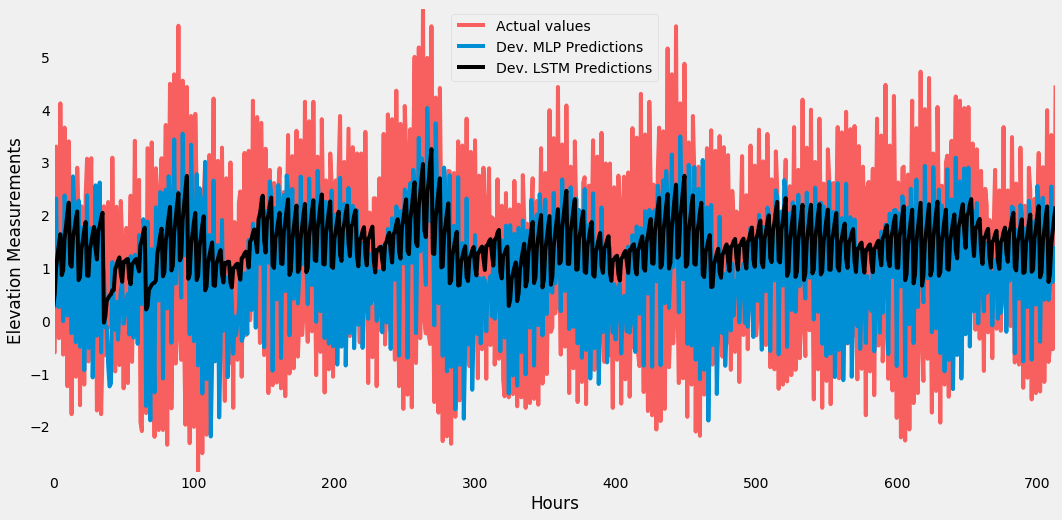

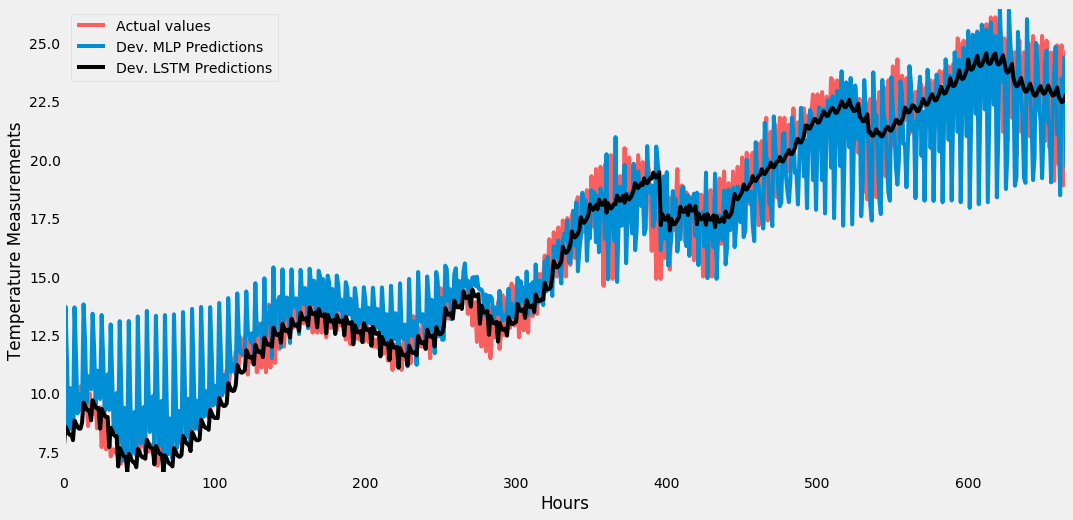

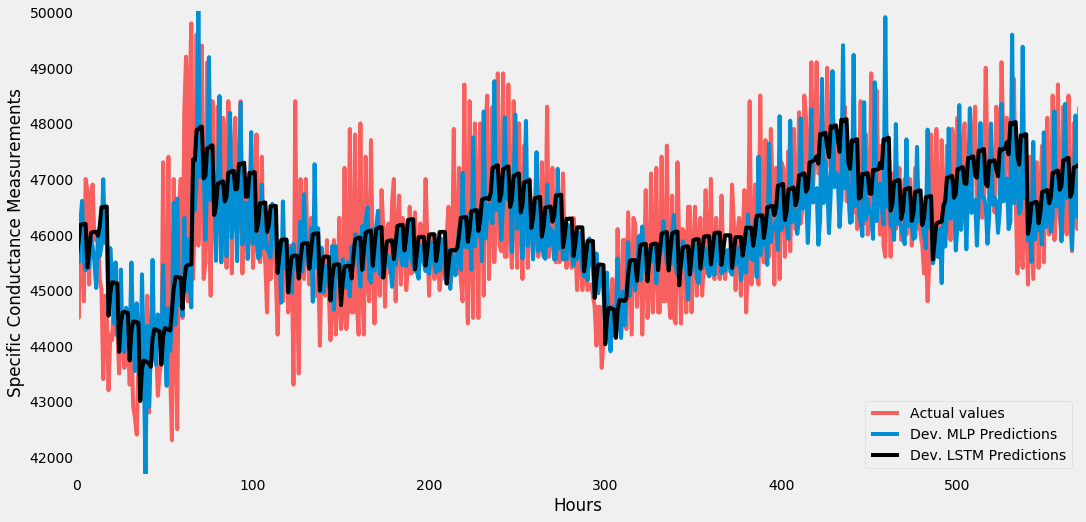

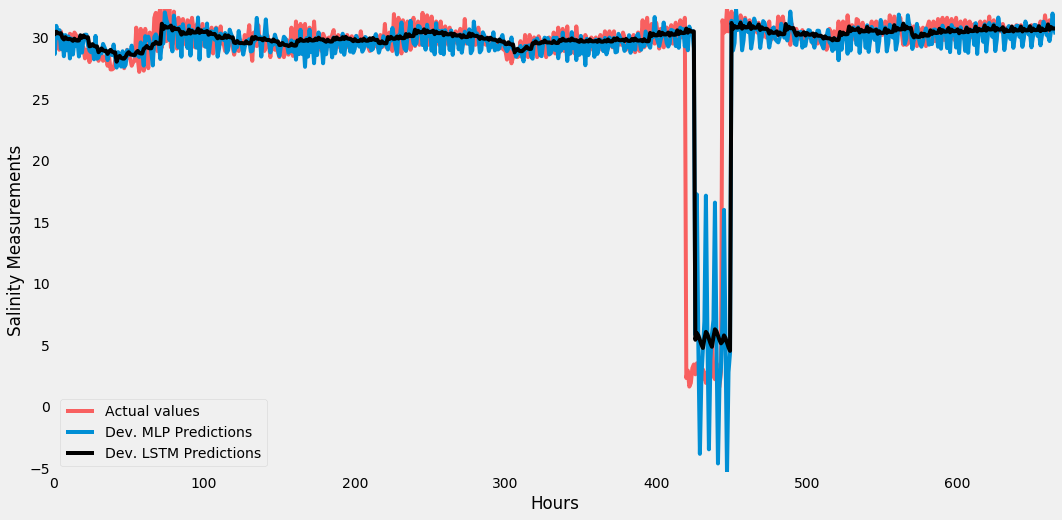

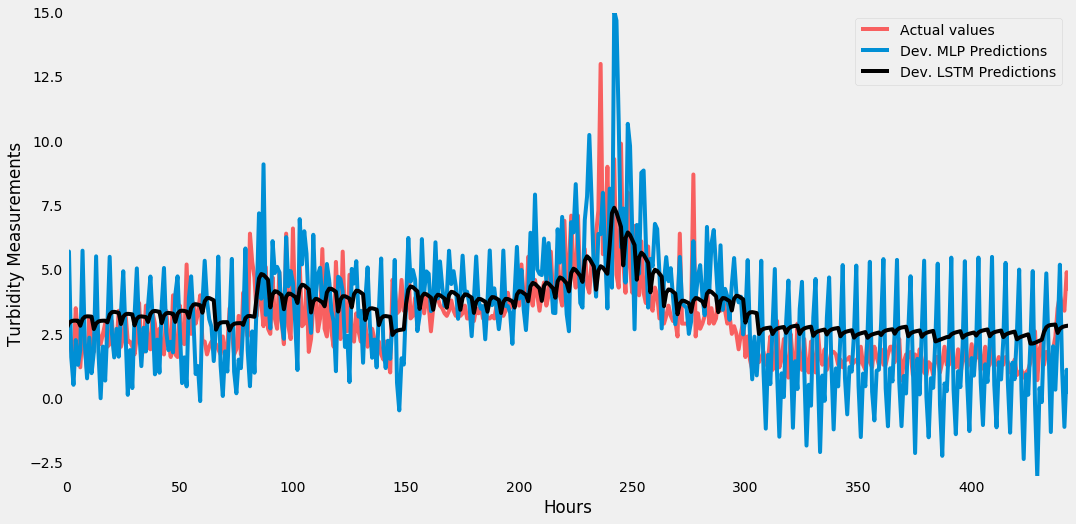

In [21]:
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
labels = ['Actual values','Dev. MLP Predictions', 'Dev. LSTM Predictions']

for i in range(5):
    print('\n')
    plt.figure(figsize=(16,8))
    plt.plot(act_list3[i].flatten(),'r-', alpha=0.6, label = labels[0])
    plt.plot(pred_list2[i][-len(pred_list3[i]):][:].flatten(), label = labels[1])
    plt.plot(pred_list3[i].flatten(),"k-", label = labels[2])
    plt.margins(0,0)
    plt.grid()
    plt.xlabel('Hours')
    plt.ylabel(FeaturesHogIsland[i]+' Measurements')
    plt.legend()
    plt.show()

# Rockaway pretrained MLP

In [22]:
warnings.filterwarnings('ignore')
df = df_rockaway

FeaturesHogIsland = ['Elevation','Temperature','Specific Conductance','Salinity','Turbidity']

acc_list4 = []
pred_list4 = []
act_list4 = []

for i in range(len(FeaturesHogIsland)):
    var = FeaturesHogIsland[i]
    mylist = df.groupby([df['datetime'].dt.date])
    xx = mylist[var].apply(list)
    date_measurements = [xx[i] for i in range(len(xx)) if len(xx[i])==240]
    date_measurements = np.array(date_measurements)
    inds = np.where(np.isnan(date_measurements))
    badind = list(set(inds[0]))
    date_measurements = np.delete(date_measurements, ([i for i in badind]), axis=0)

    inp = [date_measurements[i][j] for i in range(len(date_measurements)) for j in range(0,240,40)]
    inp = np.array(inp)
    print(var,'\n',stats.describe(inp))
    scaler = MinMaxScaler(feature_range=(0, 1))
    inp = scaler.fit_transform(inp.reshape(-1, 1))
    inp = inp.reshape(len(date_measurements),6)
    inp = inp[:(int(len(inp)*0.5))][:]
    print(inp.shape)

    out = inp[1:][:]
    inp = inp[:-1][:]

    stop = int(len(inp)*0.6)
    x_train = inp[:stop][:]
    y_train = out[:stop][:]
    x_test = inp[stop:][:]
    y_test = out[stop:][:]

    #Multi-Layer Perceptron
    MLP = model_list[i]
    MLP = MLP.fit(x_train, y_train)
    y_predict = MLP.predict(x_test)
    
    y_predict = scaler.inverse_transform(y_predict)
    y_test = scaler.inverse_transform(y_test)

    acc = mean_squared_error(y_test, y_predict)
    pred_list4.append(y_predict)
    act_list4.append(y_test)
    acc_list4.append(acc)
    
print(acc_list4)

Elevation 
 DescribeResult(nobs=7122, minmax=(-4.49, 6.63), mean=1.0441996630160066, variance=3.8199825148264557, skewness=0.031264629735598244, kurtosis=-0.9078651398102839)
(593, 6)
Temperature 
 DescribeResult(nobs=6624, minmax=(-1.7, 27.9), mean=12.930993357487921, variance=59.22970965781486, skewness=0.11612473171872587, kurtosis=-1.3378433820575406)
(552, 6)
Specific Conductance 
 DescribeResult(nobs=5664, minmax=(37400.0, 53200.0), mean=45842.51412429378, variance=3360141.7268002923, skewness=0.03751499255906756, kurtosis=0.5768687395402283)
(472, 6)
Salinity 
 DescribeResult(nobs=6678, minmax=(0.3, 37.6), mean=27.155944893680743, variance=62.208671407476544, skewness=-2.63046809259408, kurtosis=5.341193276722057)
(556, 6)
Turbidity 
 DescribeResult(nobs=4446, minmax=(0.2, 40.0), mean=2.71689158794422, variance=2.7576381196277593, skewness=4.517468354412315, kurtosis=64.9524462240701)
(370, 6)
[1.8553295270916168, 5.835434928708857, 2946065.658107663, 30.27569654260039, 5.005805

# Rockaway pretrained LSTM

In [23]:
warnings.filterwarnings('ignore')
df = df_rockaway

FeaturesHogIsland = ['Elevation','Temperature','Specific Conductance','Salinity','Turbidity']

acc_list5 = []
pred_list5 = []
act_list5 = []

for i in range(len(FeaturesHogIsland)):
    var = FeaturesHogIsland[i]
    mylist = df.groupby([df['datetime'].dt.date])
    xx = mylist[var].apply(list)
    date_measurements = [xx[i] for i in range(len(xx)) if len(xx[i])==240]
    date_measurements = np.array(date_measurements)
    inds = np.where(np.isnan(date_measurements))
    badind = list(set(inds[0]))
    date_measurements = np.delete(date_measurements, ([i for i in badind]), axis=0)

    inp = [date_measurements[i][j] for i in range(len(date_measurements)) for j in range(0,240,40)]
    inp = np.array(inp)
    print(var,'\n',stats.describe(inp))
    scaler = MinMaxScaler(feature_range=(0, 1))
    inp = scaler.fit_transform(inp.reshape(-1, 1))
    inp = inp.reshape(len(date_measurements),6)
    inp = inp[:(int(len(inp)*0.5))][:]
    print(inp.shape)

    out = inp[1:][:]
    inp = inp[:-1][:]

    stop = int(len(inp)*0.8)
    x_train = inp[:stop][:]
    y_train = out[:stop][:]
    x_test = inp[stop:][:]
    y_test = out[stop:][:]

    train_X_reshaped = x_train.reshape((x_train.shape[0], 6, 1))
    test_X_reshaped = x_test.reshape((x_test.shape[0], 6, 1))
    train_y_reshaped = y_train.reshape((y_train.shape[0], 6, 1))
    test_y_reshaped = y_test.reshape((y_test.shape[0], 6, 1))
    
    model = model_list1[i]
    history = model.fit(train_X_reshaped, train_y_reshaped, batch_size=1, epochs=10, validation_split=0.2, verbose=0)
    y_predict = model.predict(test_X_reshaped)
    
    nsamples, nx, ny = test_y_reshaped.shape
    test_y_reshaped = test_y_reshaped.reshape((nsamples,nx*ny))
    y_predict = y_predict.reshape((nsamples,nx*ny))

    y_predict = scaler.inverse_transform(y_predict)
    y_test = scaler.inverse_transform(test_y_reshaped)

    testScore = mean_squared_error(y_test, y_predict)
    
    acc = mean_squared_error(y_test, y_predict)
    pred_list5.append(y_predict)
    act_list5.append(y_test)
    acc_list5.append(acc)
    
print(acc_list5)

Elevation 
 DescribeResult(nobs=7122, minmax=(-4.49, 6.63), mean=1.0441996630160066, variance=3.8199825148264557, skewness=0.031264629735598244, kurtosis=-0.9078651398102839)
(593, 6)
Temperature 
 DescribeResult(nobs=6624, minmax=(-1.7, 27.9), mean=12.930993357487921, variance=59.22970965781486, skewness=0.11612473171872587, kurtosis=-1.3378433820575406)
(552, 6)
Specific Conductance 
 DescribeResult(nobs=5664, minmax=(37400.0, 53200.0), mean=45842.51412429378, variance=3360141.7268002923, skewness=0.03751499255906756, kurtosis=0.5768687395402283)
(472, 6)
Salinity 
 DescribeResult(nobs=6678, minmax=(0.3, 37.6), mean=27.155944893680743, variance=62.208671407476544, skewness=-2.63046809259408, kurtosis=5.341193276722057)
(556, 6)
Turbidity 
 DescribeResult(nobs=4446, minmax=(0.2, 40.0), mean=2.71689158794422, variance=2.7576381196277593, skewness=4.517468354412315, kurtosis=64.9524462240701)
(370, 6)
[0.2578723752836702, 1.2004814840499591, 1144556.6429969652, 13.7404088047164, 1.21146

In [24]:
act_list5[0].shape, act_list5[0].shape, pred_list4[0].shape

((119, 6), (119, 6), (237, 6))

# Fine-tuned MLP vs LSTM

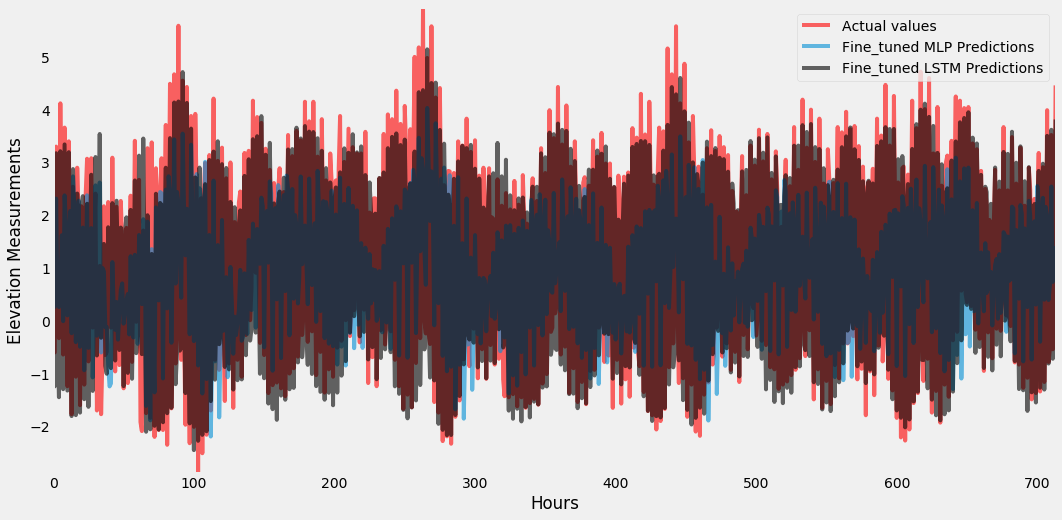

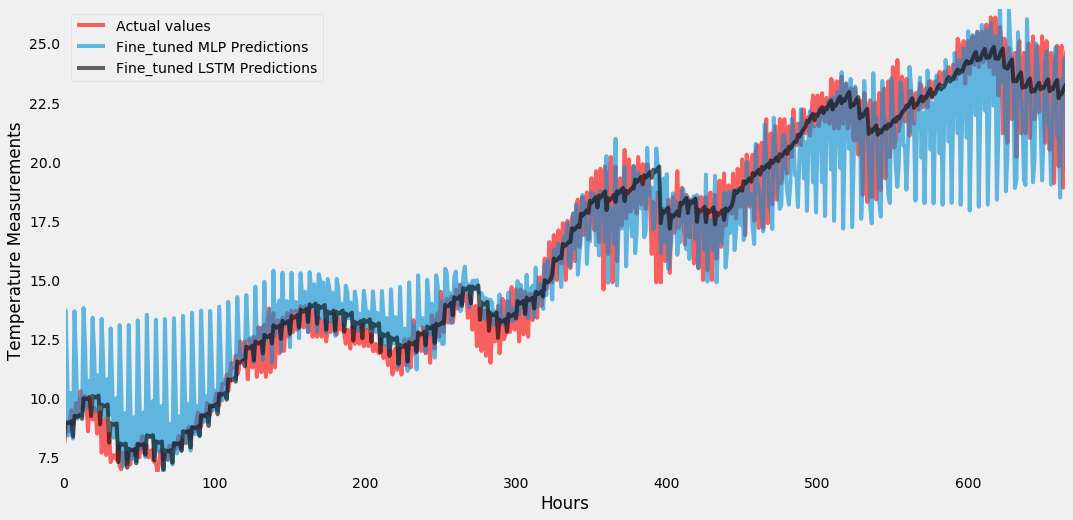

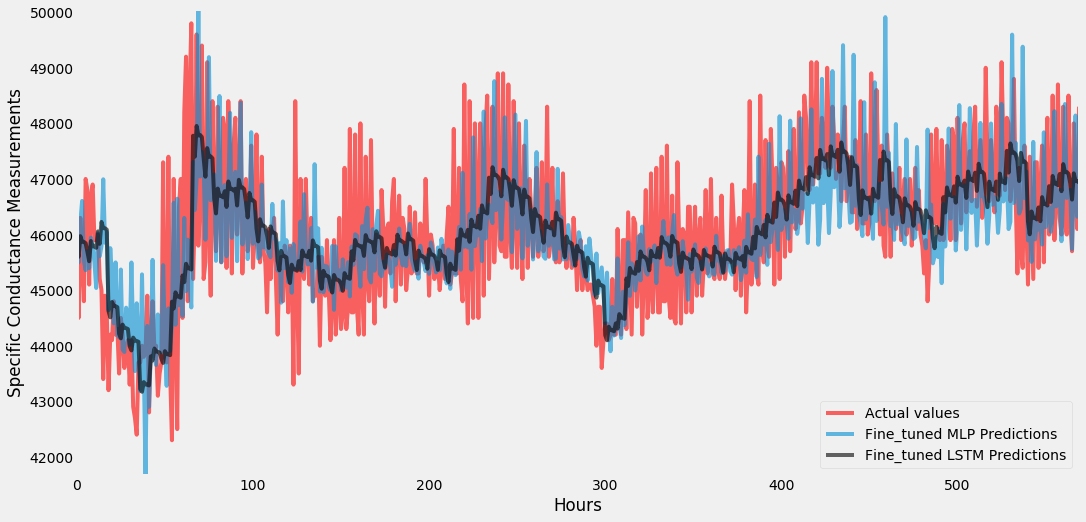

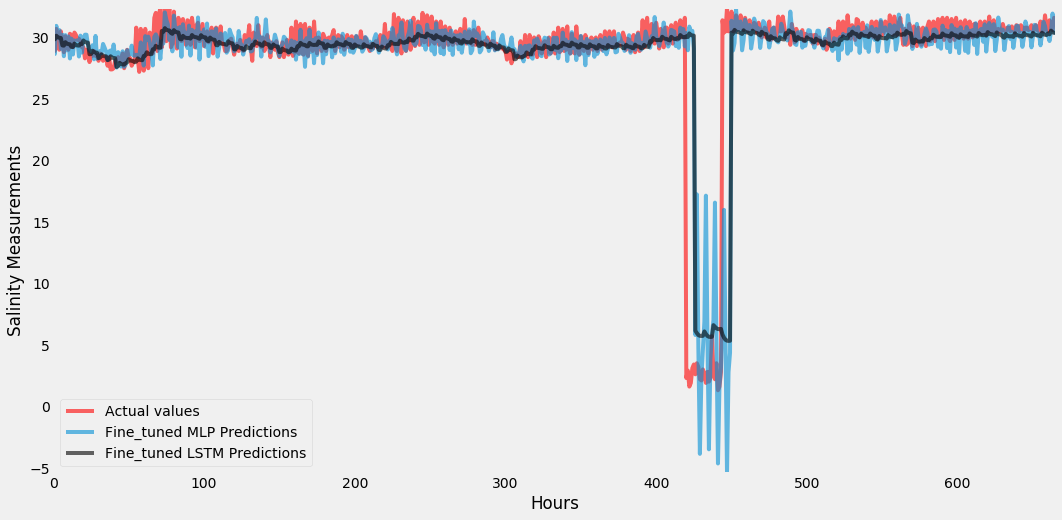

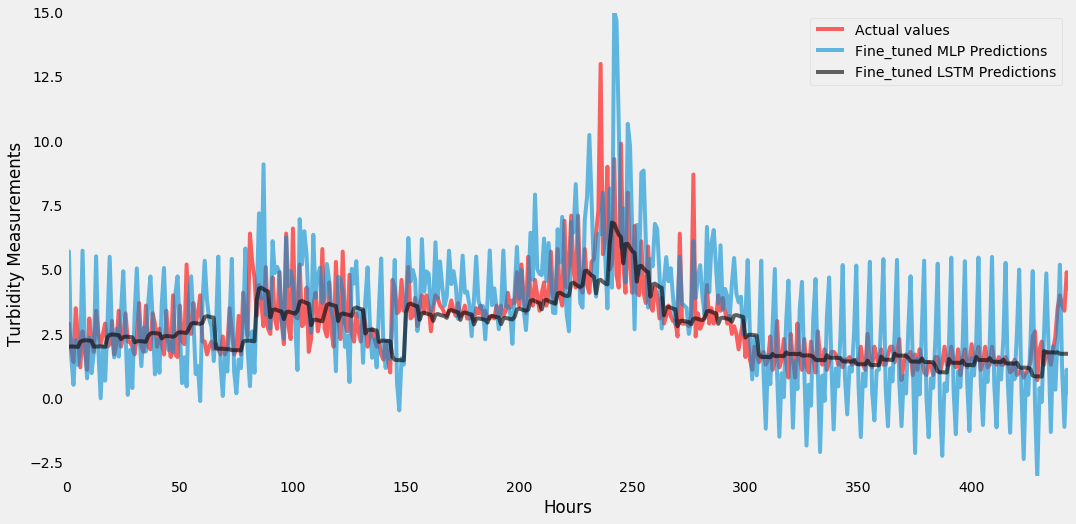

In [25]:
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
labels = ['Actual values','Fine_tuned MLP Predictions', 'Fine_tuned LSTM Predictions']

for i in range(5):
    print('\n')
    plt.figure(figsize=(16,8))
    plt.plot(act_list5[i].flatten(),'r-', alpha=0.6, label = labels[0])
    plt.plot(pred_list4[i][-len(pred_list3[i]):][:].flatten(), label = labels[1], alpha=0.6)
    plt.plot(pred_list5[i].flatten(),"k-", label = labels[2], alpha=0.6)
    plt.margins(0,0)
    plt.grid()
    plt.xlabel('Hours')
    plt.ylabel(FeaturesHogIsland[i]+' Measurements')
    plt.legend()
    plt.show()

# Dev MLP vs Fine-tuned MLP

In [26]:
pred_list2[0].shape,pred_list4[0].shape,act_list2[0].shape,act_list4[0].shape

((237, 6), (237, 6), (237, 6), (237, 6))

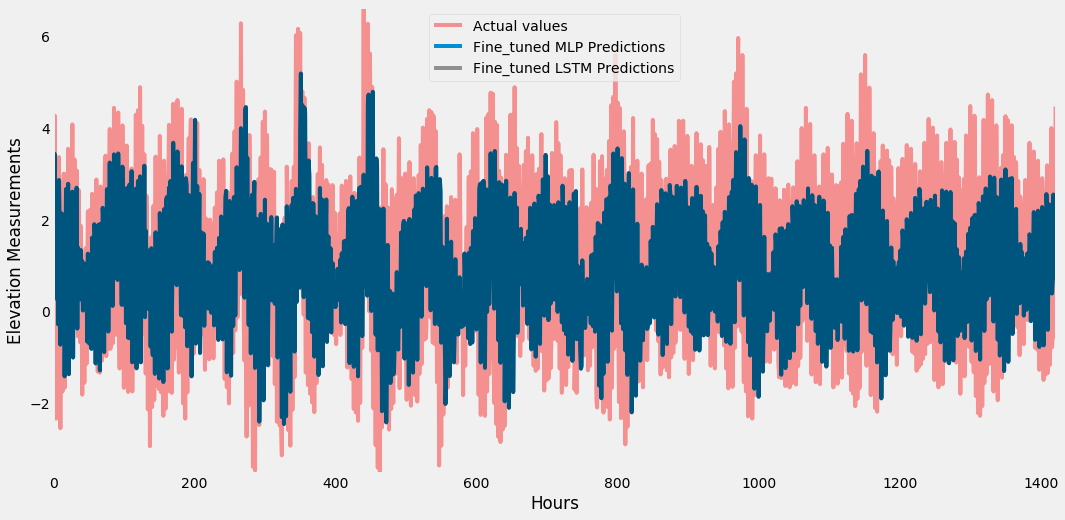

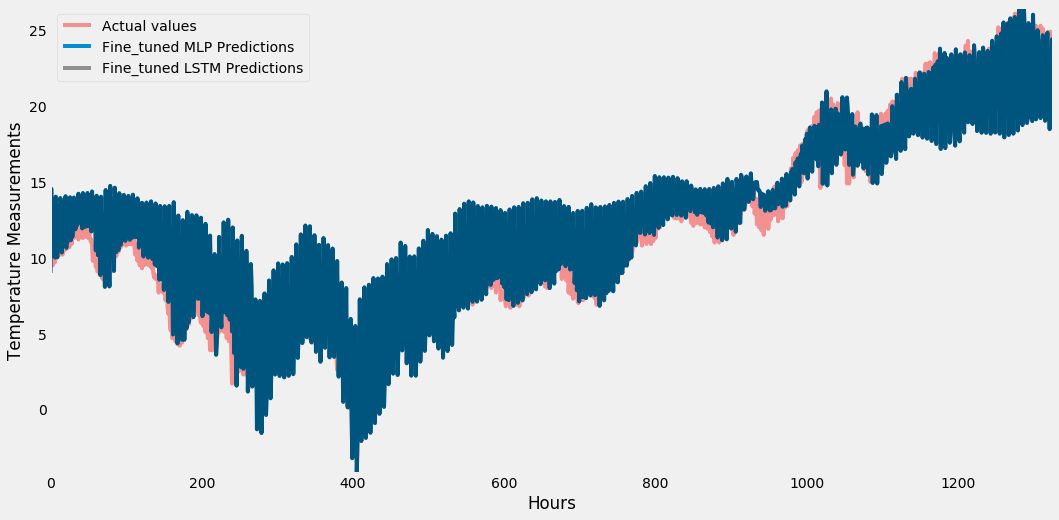

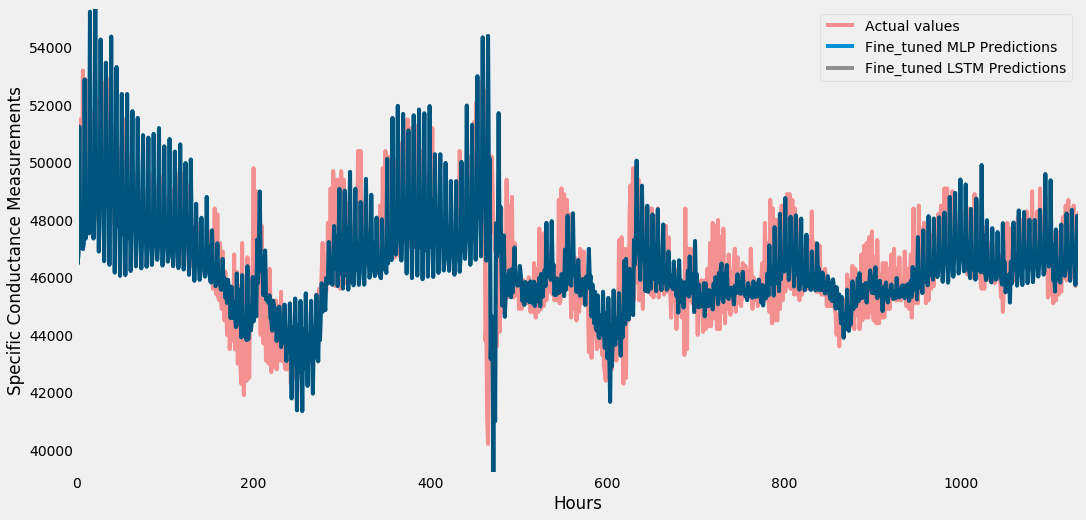

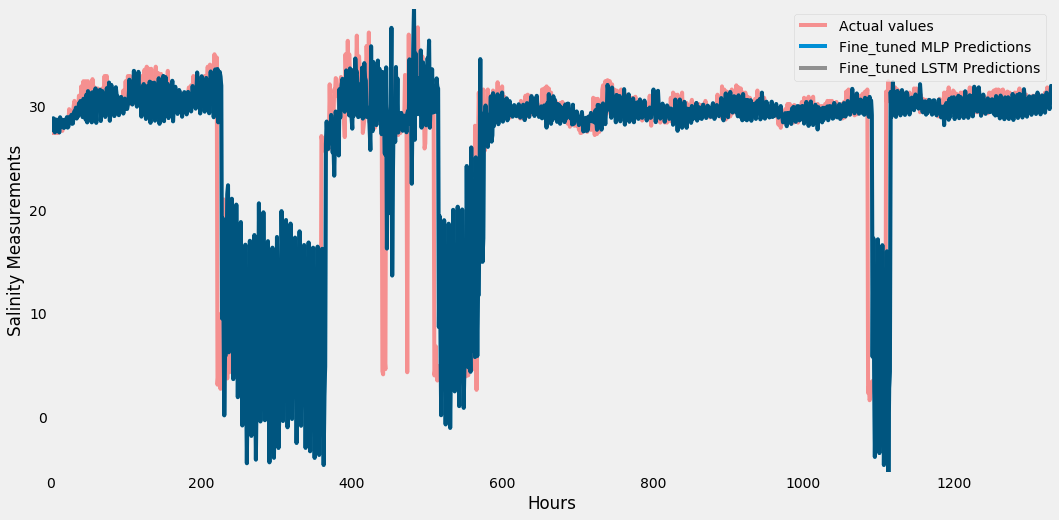

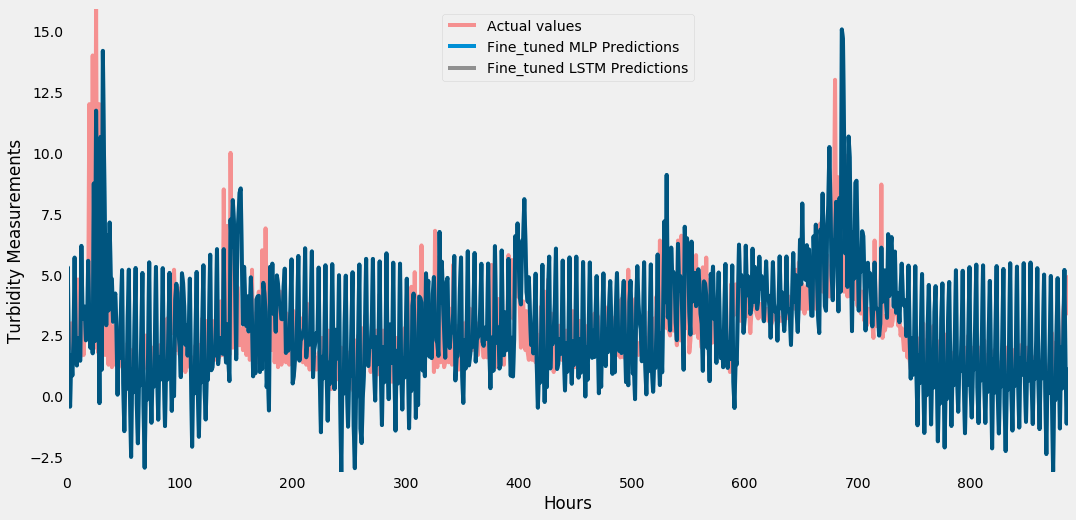

In [27]:
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
labels = ['Actual values','Fine_tuned MLP Predictions', 'Fine_tuned LSTM Predictions']

for i in range(5):
    print('\n')
    plt.figure(figsize=(16,8))
    plt.plot(act_list2[i].flatten(),'r-', alpha=0.4, label=labels[0])
    plt.plot(pred_list2[i].flatten(), label=labels[1])
    plt.plot(pred_list4[i].flatten(),'k-',alpha=0.4, label=labels[2])
    plt.margins(0,0)
    plt.grid()
    plt.xlabel('Hours')
    plt.ylabel(FeaturesHogIsland[i]+' Measurements')
    plt.legend()
    plt.show()

# Dev LSTM vs Fine_tuned LSTM

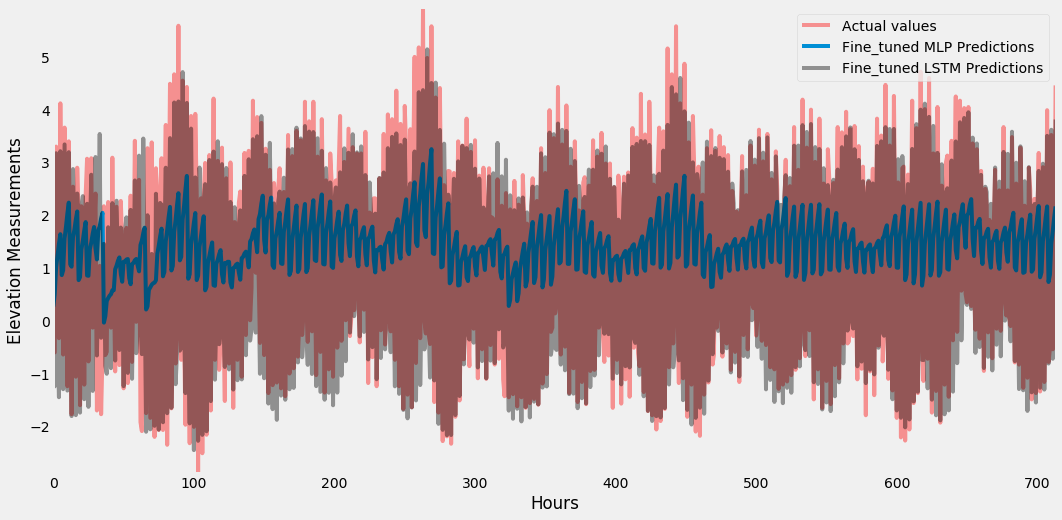

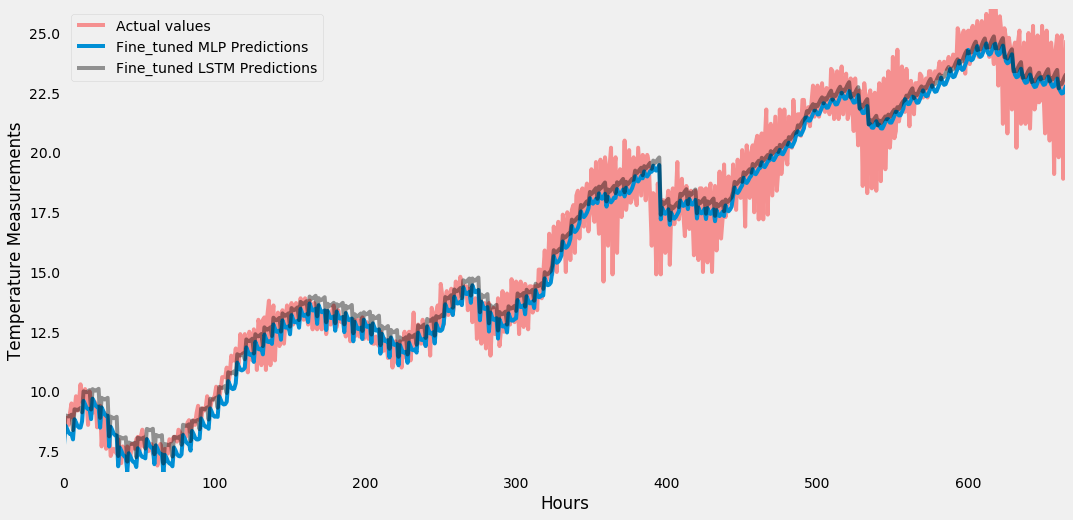

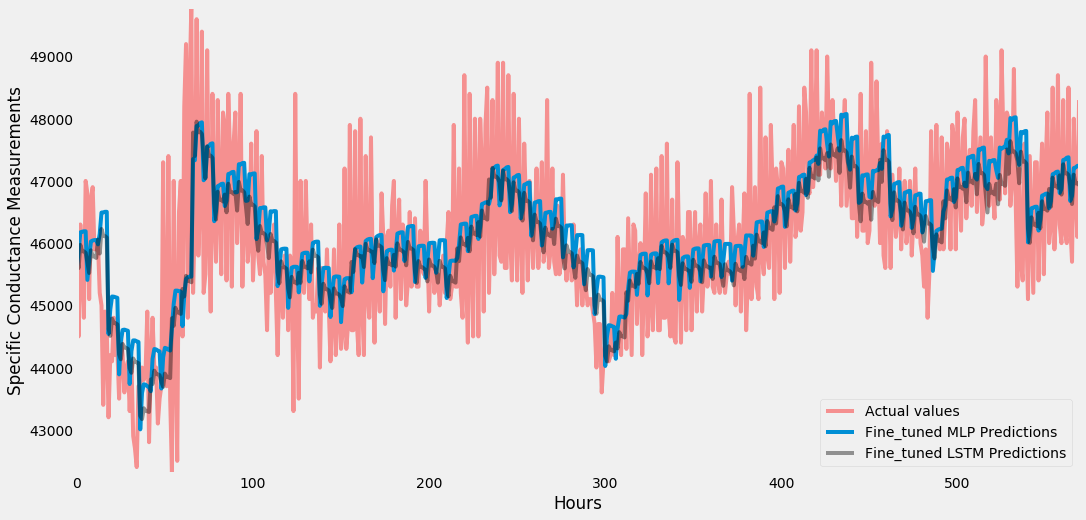

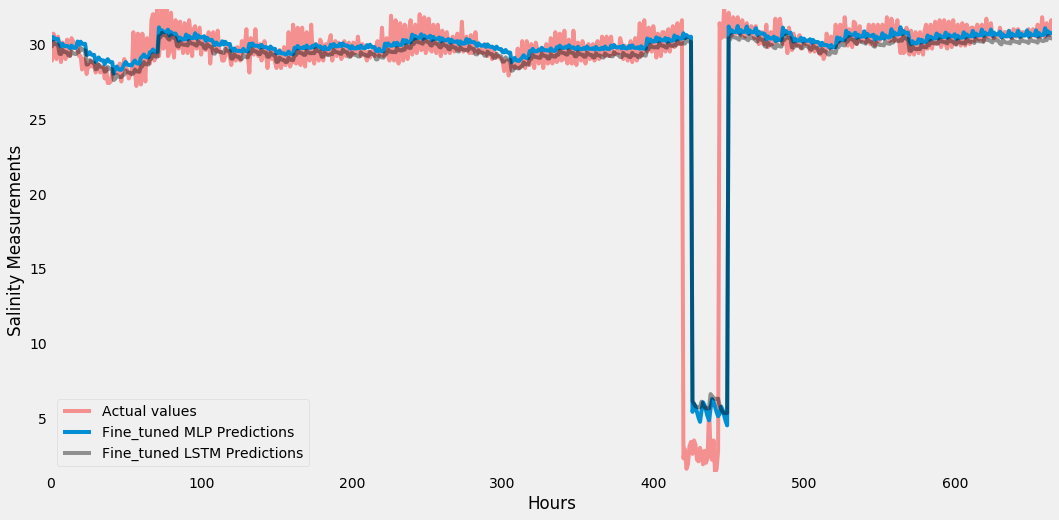

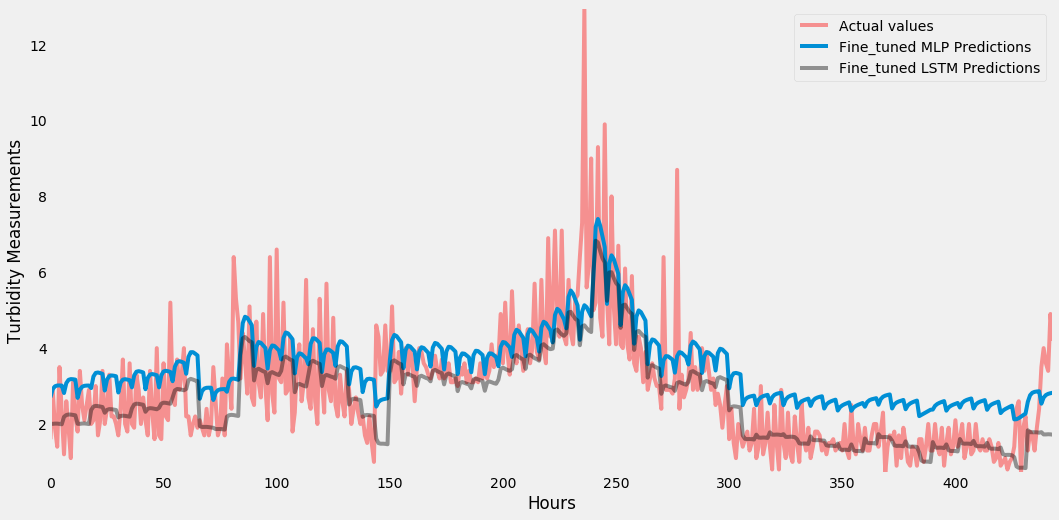

In [28]:
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
labels = ['Actual values','Fine_tuned MLP Predictions', 'Fine_tuned LSTM Predictions']

for i in range(5):
    print('\n')
    plt.figure(figsize=(16,8))
    plt.plot(act_list3[i].flatten(),'r-', alpha=0.4, label=labels[0])
    plt.plot(pred_list3[i].flatten(), label=labels[1])
    plt.plot(pred_list5[i].flatten(),'k-',alpha=0.4, label=labels[2])
    plt.margins(0,0)
    plt.grid()
    plt.xlabel('Hours')
    plt.ylabel(FeaturesHogIsland[i]+' Measurements')
    plt.legend()
    plt.show()

In [29]:
a = pred_list4[0][-len(pred_list3[0]):][:]
a = np.array(a)

In [30]:
pred_list5[0][:2][:].flatten()

array([-0.620659  , -1.2433163 ,  3.1741312 , -0.2656975 , -1.4485315 ,
        3.2125864 ,  0.50925887, -1.296447  ,  3.3415818 ,  1.0544572 ,
       -1.3230484 ,  3.1946476 ], dtype=float32)

In [31]:
from scipy.interpolate import spline

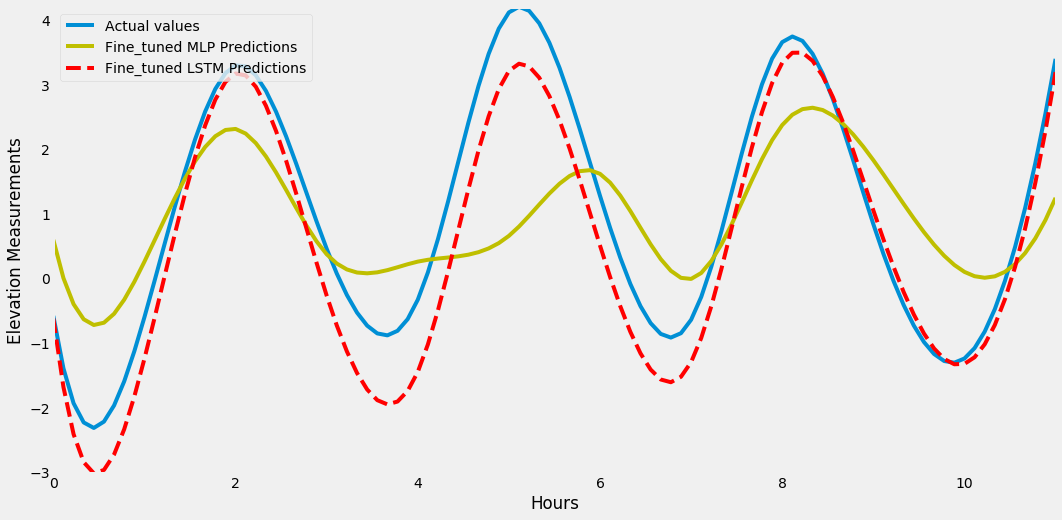

In [34]:
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
labels = ['Actual values','Fine_tuned MLP Predictions', 'Fine_tuned LSTM Predictions']
print('\n')
plt.figure(figsize=(16,8))

l0 = [i for i in range(len(act_list5[0][:2][:].flatten()))]
l0 = np.array(l0)
l0_smooth = np.linspace(l0.min(),l0.max(),100)
l1 = act_list5[0][:2][:].flatten()
l1_smooth = spline(l0,l1,l0_smooth)
l2 = a[:2][:].flatten()
l2_smooth = spline(l0,l2,l0_smooth)
l3 = pred_list5[0][:2][:].flatten()
l3_smooth = spline(l0,l3,l0_smooth)
plt.plot(l0_smooth,l1_smooth, label = labels[0])
plt.plot(l0_smooth,l2_smooth,'y-',label = labels[1])
plt.plot(l0_smooth,l3_smooth, 'r--',label = labels[2])
plt.margins(0,0)
plt.grid()
plt.xlabel('Hours')
plt.ylabel(FeaturesHogIsland[0]+' Measurements')
plt.legend(loc=2)
plt.show()